# Book Recommendation System (Using KNN Algorithm)


## Minor Project


BACHELOR OF TECHNOLOGY\
Computer Science and Engineering\
2019-2023

## Team
1. Konark Lohat
2. Gautam Jain
3. Jaskamal Singh

Dataset - http://www2.informatik.uni-freiburg.de/~cziegler/BX/

# Importing necessary packages

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading dataset with their respective (and required) features 

In [44]:
# Books dataset
books = pd.read_csv('./data/BX-Books.csv', sep = ';', error_bad_lines = False, encoding = 'latin-1')
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

# Users dataset
users = pd.read_csv('./data/BX-Users.csv', sep = ';', error_bad_lines = False, encoding='latin-1')
users.columns = ['userID', 'Location', 'Age']

# Ratings dataset
ratings = pd.read_csv('./data/BX-Book-Ratings.csv', sep = ';', error_bad_lines = False, encoding='latin-1')
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\konar\AppData\Local\Temp\ipykernel_4780\1153141283.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('./data/BX-Books.csv', sep = ';', error_bad_lines = False, encoding = 'latin-1')
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping 

In [45]:
# Books dataset
print("\033[1mBooks Dataset\033[0m")
print("Rows - ", books.shape[0])
print("Cols - ", books.shape[1])
print("Cols are - ", list(books.columns))

# Users dataset
print("\n\033[1mUsers Dataset\033[0m")
print("Rows - ", users.shape[0])
print("Cols - ", users.shape[1])
print("Cols are - ", list(users.columns))

# Ratings dataset
print("\n\033[1mRatings Dataset\033[0m")
print("Rows - ", ratings.shape[0])
print("Cols - ", ratings.shape[1])
print("Cols are - ", list(ratings.columns))

Books Dataset
Rows -  271360
Cols -  8
Cols are -  ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

Users Dataset
Rows -  278858
Cols -  3
Cols are -  ['userID', 'Location', 'Age']

Ratings Dataset
Rows -  1149780
Cols -  3
Cols are -  ['userID', 'ISBN', 'bookRating']


# Rating Distribution

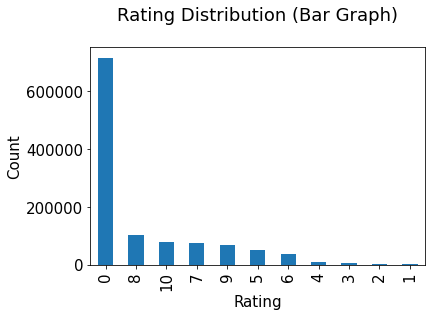

In [46]:
plt.rc('font', size = 15)
ratings.bookRating.value_counts(sort = True).plot(kind = 'bar')
plt.title("Rating Distribution (Bar Graph)\n")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('./figures/rating-distribution.png', bbox_inches = 'tight')
plt.show()

# User's Age Distribution

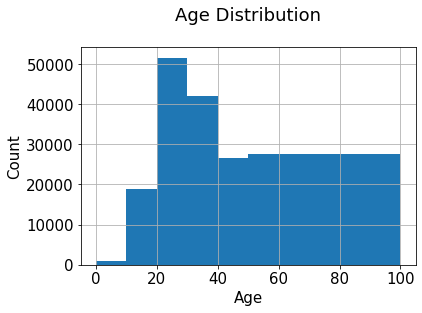

In [47]:
users.Age.hist(bins = [0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('./figures/user-age-distribution.png', bbox_inches = 'tight')
plt.show()

# To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings won't be used my the model.

In [61]:
# User's ratings
userRatingCount = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(userRatingCount[userRatingCount >= 200].index)]

# Book's ratings
bookRatingCount = ratings['bookRating'].value_counts()
print(bookRatingCount[bookRatingCount >= 100].index)
ratings = ratings[ratings['bookRating'].isin(bookRatingCount[bookRatingCount >= 100].index)]

Int64Index([0, 8, 10, 9, 7, 5, 6, 4, 3, 2, 1], dtype='int64')


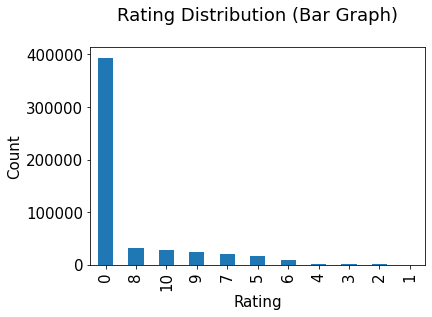

In [62]:
# TESTING THE EXCLUSION
plt.rc('font', size = 15)
ratings.bookRating.value_counts(sort = True).plot(kind = 'bar')
plt.title("Rating Distribution (Bar Graph)\n")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('./figures/rating-distribution.png', bbox_inches = 'tight')
plt.show()

# Collaborative Filtering Using K-Nearest Neighbours (KNN)


KNN is a machine learning algorithm used to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbours. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user.

In [67]:
# Combining the book and user dataset with ISBN as the primary key
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL'] # Dropped columns
combine_book_rating = combine_book_rating.drop(columns, axis = 1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


#### Now we will group by books titles and create a new column for total rating count

In [71]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_rating_count = (combine_book_rating.
                     groupby(by = ['bookTitle'])
                     ['bookRating']
                     .count()
                     .reset_index()
                     .rename(columns = {'bookRating': 'totalRatingCount'})
                     [['bookTitle', 'totalRatingCount']]
                    )

book_rating_count.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


#### We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [83]:
rating_with_total_rating_count = combine_book_rating.merge(book_rating_count, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_total_rating_count.head()

        userID        ISBN  bookRating  \
0       277427  002542730X          10   
1         3363  002542730X           0   
2        11676  002542730X           6   
3        12538  002542730X          10   
4        13552  002542730X           0   
...        ...         ...         ...   
488737  275970  1892145022           0   
488738  275970  1931868123           0   
488739  275970  3411086211          10   
488740  275970  3829021860           0   
488741  275970  4770019572           0   

                                                bookTitle  totalRatingCount  
0       Politically Correct Bedtime Stories: Modern Ta...                82  
1       Politically Correct Bedtime Stories: Modern Ta...                82  
2       Politically Correct Bedtime Stories: Modern Ta...                82  
3       Politically Correct Bedtime Stories: Modern Ta...                82  
4       Politically Correct Bedtime Stories: Modern Ta...                82  
...                        

In [82]:
popularity_threshold = 50
rating_popular_book = rating_with_total_rating_count.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [54]:
rating_popular_book.shape

(288740, 5)

# Filter users of USA and Canada only

In [78]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains('usa|canada')]
us_canada_user_rating = us_canada_user_rating.drop('Age', axis = 1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,276725,034545104X,0,Flesh Tones: A Novel,60,"tyler, texas, usa"
1,2313,034545104X,5,Flesh Tones: A Novel,60,"cincinnati, ohio, usa"
2,6543,034545104X,0,Flesh Tones: A Novel,60,"strafford, missouri, usa"
3,8680,034545104X,5,Flesh Tones: A Novel,60,"st. charles county, missouri, usa"
4,10314,034545104X,9,Flesh Tones: A Novel,60,"beaverton, oregon, usa"


# Implementing KNN (Cosine Similarity)


We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the value (ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.


Finding the Nearest Neighbours, we use unsupervised algorithms with sklearn.neighbours. The algorithm we use to compute the nearest neighbours is "brute", and we specify "metric = cosine" so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [90]:
from scipy.sparse import csr_matrix 
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [57]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [92]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

In [59]:
us_canada_user_rating_pivot.index[query_index]

'Witness in Death (Eve Dallas Mysteries (Paperback))'

In [80]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print("Recommendations for {0}:\n".format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print("{0}: {1}, with distance of {2}".format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Witness in Death (Eve Dallas Mysteries (Paperback)):

1: Seduction in Death, with distance of 0.4620604265166146
2: Judgment in Death, with distance of 0.5190443536196638
3: Reunion in Death, with distance of 0.5239857027197188
4: Purity in Death, with distance of 0.5505452214328186
5: Castles, with distance of 0.6118648730329626
